# Black Friday Purchases
source: https://platform.stratascratch.com/data-projects/black-friday-purchases

In [34]:
%matplotlib inline 

In [95]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shap
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

from ydata_profiling import ProfileReport
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LinearRegression


In [36]:
walmart = pd.read_csv("./datasets/walmart_data.csv")

In [37]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


### (1) EDA

In [38]:
numvars = walmart.select_dtypes(["int", "float"]).columns.to_list()
catvars = walmart.select_dtypes(["object"]).columns.to_list()

In [39]:
walmart[numvars].describe()

,User_ID,Occupation,Marital_Status,Product_Category,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,23961.000000


In [40]:
for eachvar in catvars:
    print(f"{eachvar}: {walmart[eachvar].unique()}")

Product_ID: ['P00069042' 'P00248942' 'P00087842' ... 'P00370293' 'P00371644'
 'P00370853']
Gender: ['F' 'M']
Age: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
City_Category: ['A' 'C' 'B']
Stay_In_Current_City_Years: ['2' '4+' '3' '1' '0']


##### Check missing

In [41]:
walmart.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category              0
Purchase                      0
dtype: int64

In [42]:
profile = ProfileReport(walmart)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
walmart.info

<bound method DataFrame.info of         User_ID Product_ID Gender    Age  Occupation City_Category  \
0       1000001  P00069042      F   0-17          10             A   
1       1000001  P00248942      F   0-17          10             A   
2       1000001  P00087842      F   0-17          10             A   
3       1000001  P00085442      F   0-17          10             A   
4       1000002  P00285442      M    55+          16             C   
...         ...        ...    ...    ...         ...           ...   
550063  1006033  P00372445      M  51-55          13             B   
550064  1006035  P00375436      F  26-35           1             C   
550065  1006036  P00375436      F  26-35          15             B   
550066  1006038  P00375436      F    55+           1             C   
550067  1006039  P00371644      F  46-50           0             B   

       Stay_In_Current_City_Years  Marital_Status  Product_Category  Purchase  
0                               2              

##### Feature engineering

In [44]:
walmart = walmart.assign(
    current_city_year=lambda x: np.where(
        x.Stay_In_Current_City_Years == "4+",
        "4",
        x.Stay_In_Current_City_Years,
    ).astype(int),
    agenum=lambda x: x.Age.case_when(
        [
            (x.Age == "0-17", 1),
            (x.Age == "18-25", 2),
            (x.Age == "26-35", 3),
            (x.Age == "36-45", 4),
            (x.Age == "46-50", 5),
            (x.Age == "51-55", 6),
            (x.Age == "55+", 7),
        ]
    ).astype(int),
    occupation2=lambda x: np.where(
        x.Occupation.isin([4, 0, 7, 1, 17, 20, 12, 14]), x.Occupation, 99
    ),
)

### (2) GBM

In [45]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
 10  current_city_year           550068 non-null  int32 
 11  agenum                      550068 non-null  int32 
 12  occupation2                 550068 non-null  int64 
dtypes: int32(2), int64(6), object

In [46]:
targetVar = ["Purchase"]
numVar = ["agenum", "current_city_year"]
catVar = ["Gender", "occupation2", "City_Category", "Marital_Status"]
predVar = numVar + catVar

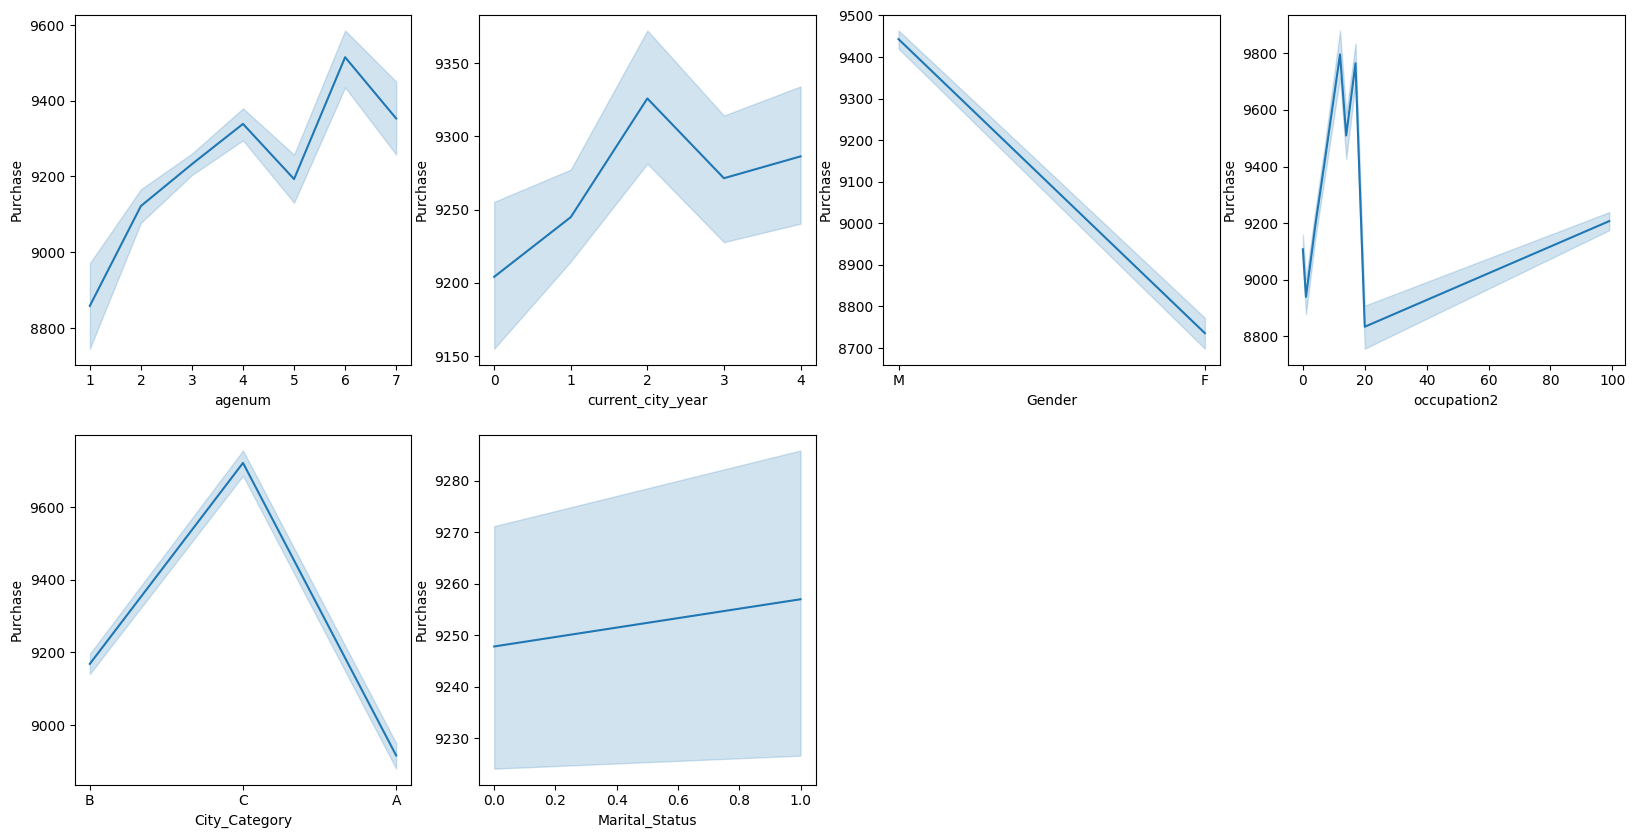

In [47]:
n = len(predVar)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

for i, eachnum in enumerate(predVar):
    sns.lineplot(data=walmart.sample(frac=0.5), x=eachnum, y="Purchase", ax=axes[i])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

In [48]:
ColTF = ColumnTransformer(
    [
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), catVar),
        ("num", "passthrough", numVar),
    ],
    remainder="drop",
)

gbmPipe = Pipeline([("ColTF", ColTF), ("gbm_regressor", GradientBoostingRegressor())])
gbmPipe.set_output(transform="pandas")


Pipeline(steps=[('ColTF',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Gender', 'occupation2',
                                                   'City_Category',
                                                   'Marital_Status']),
                                                 ('num', 'passthrough',
                                                  ['agenum',
                                                   'current_city_year'])])),
                ('gbm_regressor', GradientBoostingRegressor())])

In [49]:
predictors = walmart[predVar]
target = walmart[targetVar]
x_train, x_test, y_train, y_test = train_test_split(
    predictors, target, test_size=0.25, stratify=walmart.Gender, random_state=777
)

#### GridSearch

In [50]:
# param_grid = {
#     "gbm_regressor__n_estimators": range(200, 310, 50),
#     "gbm_regressor__subsample": [0.75, 0.8, 0.85],
#     "gbm_regressor__learning_rate": [0.3],
# }

# gbmGridSearch = GridSearchCV(
#     estimator=gbmPipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2
# )

# gridResults = gbmGridSearch.fit(x_train, y_train)
# print(f"Best Parameters: {gridResults.best_params_}")
# model01 = gridResults.best_estimator_

In [51]:
# model01 = gridResults.best_estimator_
gbmPipeFinal = Pipeline(
    [
        ("ColTF", ColTF),
        (
            "gbm_regressor",
            GradientBoostingRegressor(
                n_estimators=300, subsample=0.75, learning_rate=0.3
            ),
        ),
    ]
)
model01 = gbmPipeFinal.fit(x_train, y_train)

c:\Users\Jerry_Dell_7060\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


#### Model evaluation

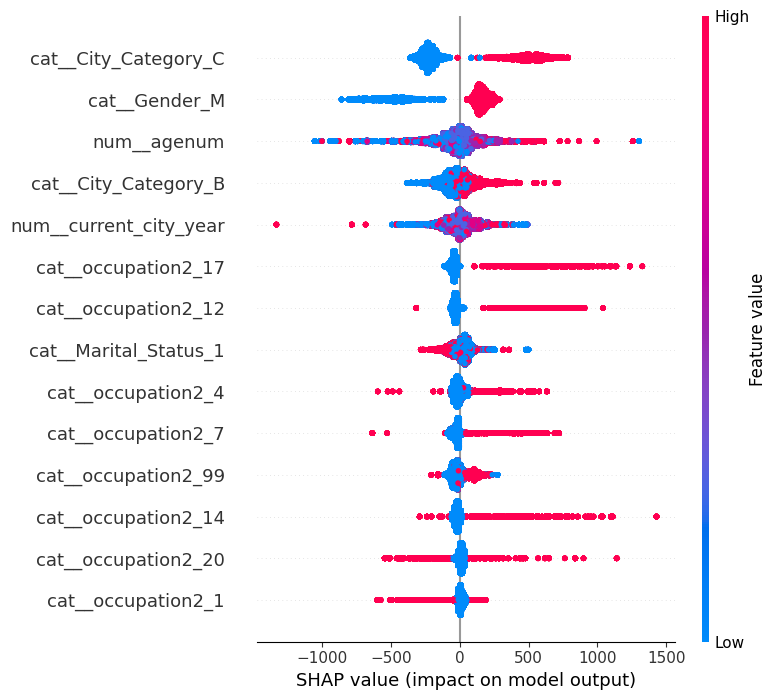

In [52]:
X_transformed = model01.named_steps["ColTF"].transform(x_train)
final_gbm_estimator = model01.named_steps["gbm_regressor"]

explainer = shap.TreeExplainer(final_gbm_estimator)
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values, X_transformed)

                   Feature  Importance
10    cat__City_Category_C    0.203876
12             num__agenum    0.187548
0            cat__Gender_M    0.182148
13  num__current_city_year    0.106449
9     cat__City_Category_B    0.062709
11   cat__Marital_Status_1    0.044699
6      cat__occupation2_17    0.037357
5      cat__occupation2_14    0.037225
4      cat__occupation2_12    0.030634
7      cat__occupation2_20    0.030191


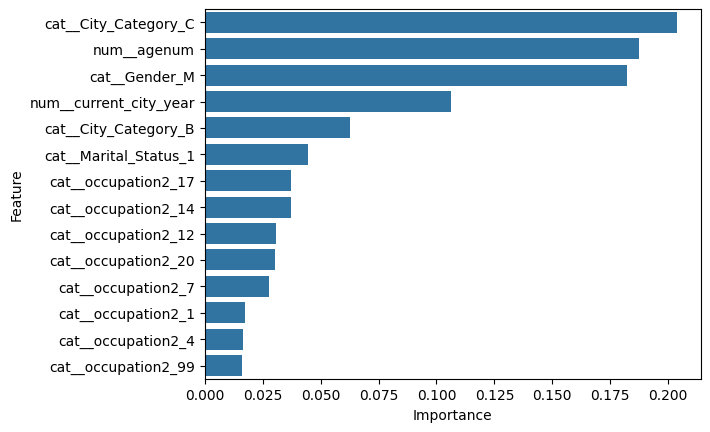

In [53]:
featureImp_df = pd.DataFrame(
    {
        "Feature": X_transformed.columns,
        "Importance": final_gbm_estimator.feature_importances_,
    }
).sort_values("Importance", ascending=False)

sns.barplot(featureImp_df, x="Importance", y="Feature")
print(featureImp_df.head(10))

In [54]:
X_transformed.columns

Index(['cat__Gender_M', 'cat__occupation2_1', 'cat__occupation2_4',
       'cat__occupation2_7', 'cat__occupation2_12', 'cat__occupation2_14',
       'cat__occupation2_17', 'cat__occupation2_20', 'cat__occupation2_99',
       'cat__City_Category_B', 'cat__City_Category_C', 'cat__Marital_Status_1',
       'num__agenum', 'num__current_city_year'],
      dtype='object')

In [55]:
X_transformed = X_transformed.reindex(featureImp_df.Feature, axis=1)

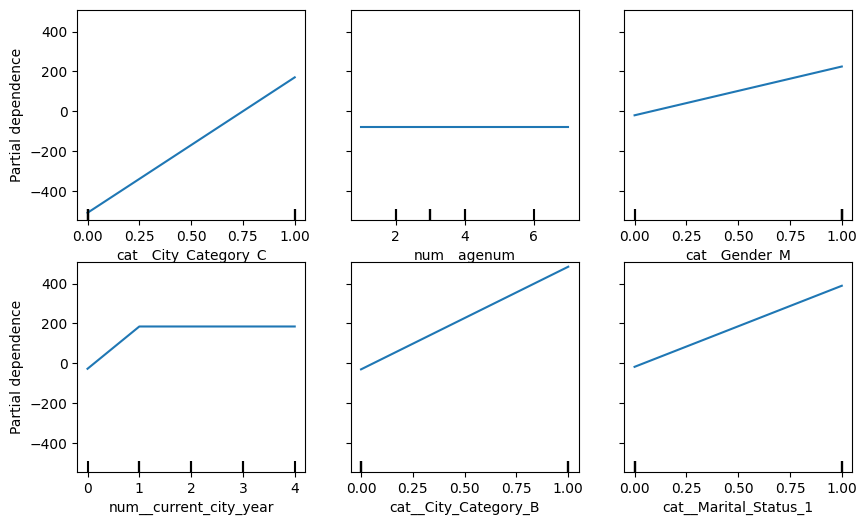

In [56]:
displayplot = PartialDependenceDisplay.from_estimator(
    final_gbm_estimator, X_transformed, features=range(0, 6)
)
displayplot.figure_.set_size_inches(10, 6)

Male spend more than Female

### (3) Linear regression
This is not a necessary step but just want to practice.
Sklearn modules do not provide p-values
statmodel modules provide p-values

#### Sklean module (as reference)

In [59]:
glmPipeFinal = Pipeline(
    [
        ("ColTF", ColTF),
        ("glm_regressor", LinearRegression()),
    ]
)
model02 = glmPipeFinal.fit(x_train, y_train)

In [ ]:
X_transformed = model02.named_steps["ColTF"].transform(x_train)

glmcoef = pd.DataFrame(
    {
        "features": X_transformed.columns,
        "coeff": model02.named_steps["glm_regressor"].coef_[0],
    }
)

glmcoef


,features,coeff
0,cat__Gender_M,642.798706
1,cat__occupation2_1,-133.662896
2,cat__occupation2_4,151.993303
3,cat__occupation2_7,208.498287
4,cat__occupation2_12,519.382174
5,cat__occupation2_14,353.748967
6,cat__occupation2_17,523.751527
7,cat__occupation2_20,-200.898689
8,cat__occupation2_99,44.701358
9,cat__City_Category_B,213.473976


#### statmodel

In [ ]:
full_train = pd.concat([X_transformed, y_train], axis=1)
full_train.columns

Index(['cat__Gender_M', 'cat__occupation2_1', 'cat__occupation2_4',
       'cat__occupation2_7', 'cat__occupation2_12', 'cat__occupation2_14',
       'cat__occupation2_17', 'cat__occupation2_20', 'cat__occupation2_99',
       'cat__City_Category_B', 'cat__City_Category_C', 'cat__Marital_Status_1',
       'num__agenum', 'num__current_city_year', 'Purchase'],
      dtype='object')

In [101]:
glm_model = smf.glm(
    formula="Purchase ~ cat__Gender_M \
                    + cat__occupation2_1 \
                    + cat__occupation2_4 \
                    + cat__occupation2_7  \
                    + cat__occupation2_12 \
                    + cat__occupation2_14 \
                    + cat__occupation2_17 \
                    + cat__occupation2_20 \
                    + cat__occupation2_99 \
                    + cat__City_Category_B \
                    + cat__City_Category_C \
                    + cat__Marital_Status_1 \
                    + num__agenum \
                    + num__current_city_year",
    data=full_train,
    family=sm.families.Gaussian(link=sm.families.links.identity()),
)
fittedmodel = glm_model.fit()
fittedmodel.summary()

c:\Users\Jerry_Dell_7060\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Purchase   No. Observations:               412551
Model:                            GLM   Df Residuals:                   412536
Model Family:                Gaussian   Df Model:                           14
Link Function:               identity   Scale:                      2.5007e+07
Method:                          IRLS   Log-Likelihood:            -4.0992e+06
Date:                Sat, 16 Nov 2024   Deviance:                   1.0316e+13
Time:                        21:20:19   Pearson chi2:                 1.03e+13
No. Iterations:                     3   Pseudo R-squ. (CS):           0.009632
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8178.8765     36.791    222.304      0.000    8106.767    8250.986
cat__Gender_M            642.7987     18.326     35.076      0.000     606.880     678.717
cat__occupation2_1      -133.6629     34.630     -3.860      0.000    -201.536     -65.789
cat__occupation2_4       151.9933     31.358      4.847      0.000      90.532     213.455
cat__occupation2_7       208.4983     32.463      6.423      0.000     144.872     272.125
cat__occupation2_12      519.3822     39.442     13.168      0.000     442.076     596.688
cat__occupation2_14      353.7490     41.321      8.561      0.000     272.762     434.736
cat__occupation2_17      523.7515     36.506     14.347      0.000     452.201     595.302
cat__occupation2_20     -200.8987     38.470     -5.222      0.000    -276.299    -125.498
cat__occupation2_99       44.7014     26.075      1.714      0.086      -6.404      95.807
cat__City_Category_B     213.4740     19.312     11.054      0.000     175.623     251.325
cat__City_Category_C     769.9673     20.784     37.047      0.000     729.232     810.702
cat__Marital_Status_1    -46.0793     16.701     -2.759      0.006     -78.812     -13.346
num__agenum               43.9346      6.455      6.806      0.000      31.283      56.586
num__current_city_year    13.0962      6.049      2.165      0.030       1.241      24.951
==========================================================================================
"""